In [1]:
# pip install azure-ai-textanalytics mlflow

In [ ]:
# pip install mlflow
# autentification sur Databricks CE
import mlflow
mlflow.login()

2024/10/16 17:15:55 INFO mlflow.utils.credentials: No valid Databricks credentials found, please enter your credentials...


In [3]:
# Asignation de Databricks CE comme serveur de tracking
mlflow.set_tracking_uri("databricks")
# Création de l'expérimentation "approche classique"
mlflow.set_experiment("/Users/cecilemayer@live.com/azure_language_analytics")

<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/1027352006989850', creation_time=1729088742627, experiment_id='1027352006989850', last_update_time=1729088742627, lifecycle_stage='active', name='/Users/cecilemayer@live.com/azure_language_analytics', tags={'mlflow.experiment.sourceName': '/Users/cecilemayer@live.com/azure_language_analytics',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'cecilemayer@live.com',
 'mlflow.ownerId': '516447469672104'}>

In [45]:
import os

# This example requires environment variables named "LANGUAGE_KEY" and "LANGUAGE_ENDPOINT"
language_key = "c2a3a85df2864bbd88d18e2006d64bf4"
# os.environ.get('LANGUAGE_KEY')
language_endpoint = "https://aiep7-2.cognitiveservices.azure.com/"
# os.environ.get('LANGUAGE_ENDPOINT')


In [46]:
from azure.ai.textanalytics import TextAnalyticsClient
from azure.core.credentials import AzureKeyCredential

In [47]:
# Authenticate the client using your key and endpoint 
def authenticate_client():
    ta_credential = AzureKeyCredential(language_key)
    text_analytics_client = TextAnalyticsClient(
            endpoint=language_endpoint, 
            credential=ta_credential)
    return text_analytics_client

client = authenticate_client()

In [48]:
# 2. Fonction pour analyser le sentiment d'un texte
def sentiment_analysis(client, documents):
    sentiments = []
    batch_size = 10  # Azure ne permet pas plus de 10 documents par requête

    for i in range(0, len(documents), batch_size):
        batch = documents[i:i + batch_size]  # Diviser les documents en lots de 10
        response = client.analyze_sentiment(documents=batch)
        for doc in response:
            if not doc.is_error:
                sentiment = 0 if doc.sentiment == "positive" else 1
                sentiments.append(sentiment)
            else:
                sentiments.append(None)  # Pour gérer les erreurs éventuelles
    return sentiments

In [49]:
# 3. Analyser le dataframe
def add_sentiment_column(data, column):
    client = authenticate_client()
    documents = data[column].tolist()  # Extraire les textes à analyser
    sentiments = sentiment_analysis(client, documents)  # Analyser le sentiment
    
    new_column_name = f"azure_sentiment_{column}"  # Concaténer azure_sentiment avec le nom de la colonne
    data[new_column_name] = sentiments  # Ajouter les résultats comme nouvelle colonne
    
    return data

In [50]:
import pandas as pd
data = pd.read_csv("./data/test_df.csv", index_col=0)

In [51]:
# Ajouter la colonne 'azure_sentiment_preprocessed_text'
data = add_sentiment_column(data, "preprocessed_text")

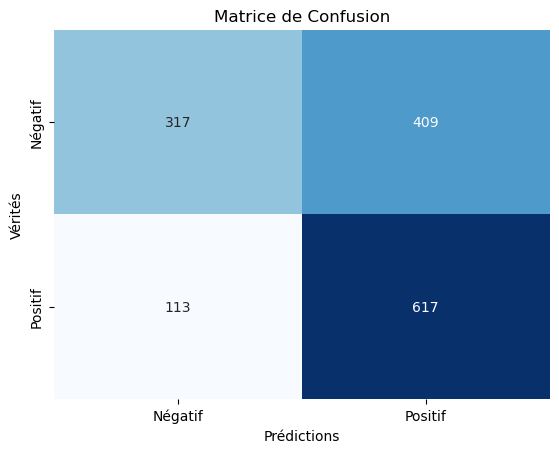

Rapport de Classification:

              precision    recall  f1-score   support

     Négatif       0.74      0.44      0.55       726
     Positif       0.60      0.85      0.70       730

    accuracy                           0.64      1456
   macro avg       0.67      0.64      0.63      1456
weighted avg       0.67      0.64      0.63      1456



In [52]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Afficher la matrice de confusion
def plot_confusion_matrix(data):
    y_true = data['target']  # Labels réels
    y_pred = data['azure_sentiment_preprocessed_text']  # Prédictions
    cm = confusion_matrix(y_true, y_pred)  # Calculer la matrice de confusion
    
    # Afficher la matrice de confusion avec seaborn pour une meilleure visualisation
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=['Négatif', 'Positif'], 
                yticklabels=['Négatif', 'Positif'])
    plt.xlabel('Prédictions')
    plt.ylabel('Vérités')
    plt.title('Matrice de Confusion')
    plt.show()

# 2. Afficher le rapport de classification
def print_classification_report(data):
    y_true = data['target']  # Labels réels
    y_pred = data['azure_sentiment_preprocessed_text']  # Prédictions
    report = classification_report(y_true, y_pred, target_names=['Négatif', 'Positif'])
    print("Rapport de Classification:\n")
    print(report)

# Afficher la matrice de confusion
plot_confusion_matrix(data)

# Afficher le rapport de classification
print_classification_report(data)

In [53]:
# Ajouter la colonne 'azure_sentiment_text'
data = add_sentiment_column(data, "text")
data.head()

,target,ids,date,flag,user,text,sentiment_score,cleaned_text,tokenized,preprocessed_text,preprocessed_tokenized,length_tokenized,length_preprocessed_tokenized,sia_sentiment,azure_sentiment_preprocessed_text,azure_sentiment_text
1191245,0,1983861581,Sun May 31 13:58:55 PDT 2009,NO_QUERY,navb01,Just got the new flight of the conchords cd!,4,Just got the new flight of the Concords CD!,"['Just', 'got', 'the', 'new', 'flight', 'of', ...",got new flight concord cd !,"['got', 'new', 'flight', 'concord', 'cd', '!']",10,6,1,1,0
1130604,0,1975724039,Sat May 30 15:45:55 PDT 2009,NO_QUERY,blyan,Sounders vs Crew Tonight. Sigi's revenge! I'll...,4,Sounders vs Crew Tonight. Sign's revenge! I wi...,"['Sounders', 'vs', 'Crew', 'Tonight', '.', 'Si...",sounder v crew tonight sign 's revenge ! one ...,"['sounder', 'v', 'crew', 'tonight', 'sign', ""'...",32,20,1,1,1
864761,0,1677346161,Sat May 02 01:36:20 PDT 2009,NO_QUERY,AWsimplybasic,":o gotta leave for mahh plane in a lil, gonna ...",4,":o got to leave for math plane in a little, go...","[':', 'o', 'got', 'to', 'leave', 'for', 'math'...",got leave math plane little going get early ...,"['got', 'leave', 'math', 'plane', 'little', 'g...",27,11,1,1,1
1007468,0,1880709139,Fri May 22 02:12:59 PDT 2009,NO_QUERY,Dutchrudder,Even the A team can't find @Jimmy_Poodle !!!! ...,4,Even the A team cannot find <mention> !! So yo...,"['Even', 'the', 'A', 'team', 'can', 'not', 'fi...",even team find <mention> ! ! better <hashtag> ...,"['even', 'team', 'find', '<mention>', '!', '!'...",24,12,0,0,1
446261,1,2068363279,Sun Jun 07 13:57:28 PDT 2009,NO_QUERY,change02,Looks like I may have missed my flight by lite...,0,Looks like I may have missed my flight by lite...,"['Looks', 'like', 'I', 'may', 'have', 'missed'...",look like may missed flight literally minute,"['look', 'like', 'may', 'missed', 'flight', 'l...",13,7,0,1,1


In [54]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import pandas as pd

# Supposons que vous avez un DataFrame `data` avec les colonnes `azure_sentiment_text` et `target`
y_true = data['target']  # Étiquettes réelles
y_pred = data['azure_sentiment_text']  # Prédictions du classifieur

accuracy = accuracy_score(y_true, y_pred)
report = classification_report(y_true, y_pred, output_dict=True)
cm = confusion_matrix(y_true, y_pred)

In [55]:
# Convertir le rapport en DataFrame
report_df = pd.DataFrame(report).transpose()

# Afficher le DataFrame
print(report_df)

              precision    recall  f1-score      support
0              0.798186  0.484848  0.603256   726.000000
1              0.631527  0.878082  0.734670   730.000000
accuracy       0.682005  0.682005  0.682005     0.682005
macro avg      0.714857  0.681465  0.668963  1456.000000
weighted avg   0.714628  0.682005  0.669144  1456.000000


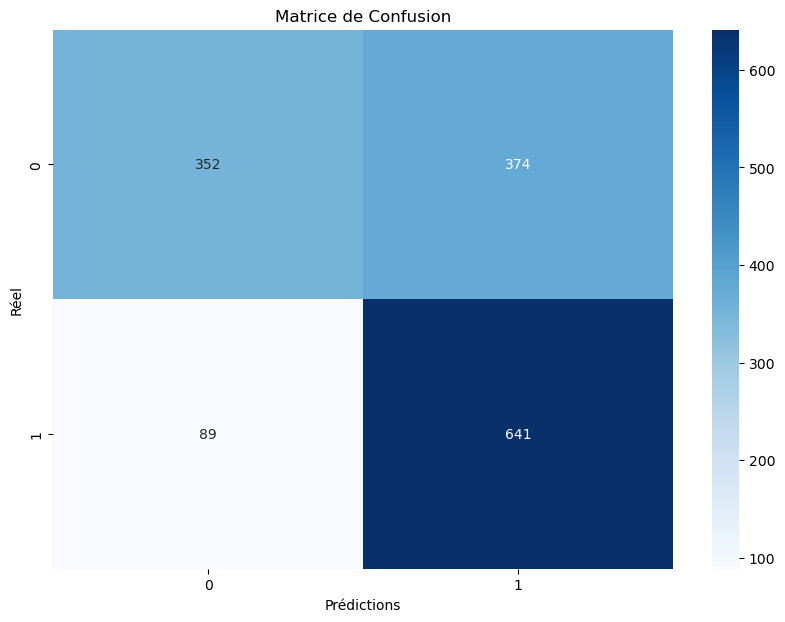

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Afficher la matrice de confusion
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Réel')

# Sauvegarder la figure
plt.savefig("confusion_matrix.png")
plt.show()  # Ajouter cette ligne pour afficher la figure
plt.close()


A partir de la colonne "text" (non pré-traité): on a arrive à un taux de détection des positifs élevé, mais en contrepartie la classe négative comporte de nombreuses erreurs ce qui résulte en un nombre important de faux positifs. Les faux négatifs sont très limités, ce qui est la tendance voulue: on ne veut pas louper les mauvaises appréciations. Dans ce modèle on a une vision pessimiste de l'appréciation des tweets.<br>
Le modèle depuis le texte prétraité possèlde les mêmes caractéristiques mais il est moins performant: l'exactitude de prédiction moyenne est légèrement inférieure.

In [57]:
data.to_csv("./data/test_azure.csv", index=True)

In [59]:
with mlflow.start_run():
    # Enregistrer les métriques
    mlflow.log_metric("accuracy", accuracy)
    for label, metrics in report.items():
        if label not in ['accuracy', 'macro avg', 'weighted avg']:  # Ignorer les moyennes
            mlflow.log_metric(f"precision_{label}", metrics['precision'])
            mlflow.log_metric(f"recall_{label}", metrics['recall'])
            mlflow.log_metric(f"f1-score_{label}", metrics['f1-score'])

    # Enregistrer la matrice de confusion
    mlflow.log_artifact("confusion_matrix.png")
    mlflow.log_artifact("./data/test_azure.csv")

RestException: TEMPORARILY_UNAVAILABLE: The service at /api/2.0/mlflow/runs/create is temporarily unavailable. Please try again later. [TraceId: -]